In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Read and manipulate data

In [5]:
## Defined functions

def convert_drugs(value):
    """
    Clean up weird values for drugs text box
    :param value: value to convert
    :return: categegorical value
    """
    if value == "Caffeine (energy drinks/coffee)" or \
        value == "Caffeine (energy drinks/coffee), Kohvi on elu, kohvi on armastus :) " or \
        value == "Herbal tea" or value == 'herbal tea' or value == "tee":
        return "Caffeine"
    elif value.startswith("Ei") or value == "No" or value == "no" or value == "food" or value == "sweets":
        return "No"
    return value


def merge_ids(id, *other_ids):
    for other_id in other_ids:
        common["user_id"].loc[common["user_id"] == other_id] = id
        general.rename(index={other_id: id}, inplace=True)


def remove_users(ids):
    global common, general
    for i in ids:
        common = common[common["user_id"] != i]
        general.drop(i, inplace=True, errors="ignore")

def change_hunger_level(to_level, *from_level):
    for level in from_level:
        common["hungry"].loc[common["hungry"] == level] = to_level

In [6]:
## Read data in

general = pd.read_csv("out_general.csv", names=["row", "ts", "user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     usecols=["user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     header=0, 
                     dtype={'gender':'category', 
                            'age':'category', 
                            'prev_test':'category', 
                            'pys_activity':'category', 
                            'sick':'category', 
                            'pain_general':'category', 
                            'pain_digest':'category', 
                            'sleep_regular':'category'
                           },
                      index_col=0)
common = pd.read_csv("out_common.csv", names=["ts", "user_id", "res_number", "res_reaction", "res_visual", "hungry", "sleepy", "time_sleep", "time_wake", "stress",
                                              "fatigue_mental", "fatigue_physical", "drugs"], header=0, 
                     converters={'ts':lambda v: pd.Timestamp(v), 
                                 'time_sleep':lambda v: pd.to_timedelta(v), 
                                 'time_wake':lambda v: pd.to_timedelta(v),
                                 'drugs': convert_drugs},
                     dtype={'hungry':'category', 
                            'sleepy':'category', 
                            'stress':'category', 
                            'fatigue_mental':'category', 
                            'fatigue_physical':'category'})

common["drugs"] = common["drugs"].astype('category')
common["hungry"] = common["hungry"].cat.add_categories(['3+'])

In [7]:
## Cleanup users

## Merge misspelled usernames
pd.set_option("mode.chained_assignment", None)

merge_ids(1, 29, 33, 34, 36)
merge_ids(35, 37)
merge_ids(4, 13, 7)
merge_ids(17, 41)
merge_ids(10, 38)
merge_ids(8, 40)
merge_ids(18, 45)

## Noinspection PyUnreachableCode
if True:
    ## Remove users with various faults
    remove_users([10, 14, 18])

    ## Remove sick people
    sick_people_ids = general[general["sick"] == "Yes"].index
    remove_users(sick_people_ids)

common = common.reset_index(drop=True)
general.sort_index(inplace=True)

## Filter people who either failed at filling out general or didn't do any tests
empty_ids = set(common.user_id.unique()) ^ set(general.index)
remove_users(empty_ids)

## Remove people who did less than 4 tests TODO maybe more?
test_counts = common["user_id"].value_counts()
almost_empty_ids = test_counts[test_counts < 4].index
remove_users(almost_empty_ids)

## Remove results with too much stress
common = common[(common["stress"] != '4') & (common["stress"] != '5')]

## Alter hungry level 3 & 4 & 5 to 3+
change_hunger_level('3+', '3', '4', '5')

## Scores

### Visualize scores

KeyError: 'awake_bin'

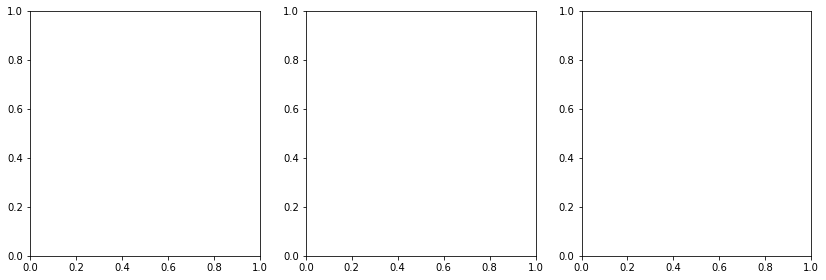

In [8]:
res_columns = ["res_reaction", "res_visual", "res_number"]

fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))
for column, plot in zip(res_columns, plots):

    #common.plot.scatter(x="user_id", y=column, title=column, ax=plot)
    common.boxplot(by="awake_bin", column=column, ax=plot)

In [ ]:
test_counts[test_counts >= 9].describe()

### Normalize scores

In [9]:
import warnings
from sklearn import preprocessing
from sklearn.exceptions import DataConversionWarning

# TODO maybe scale logarithmically. reason: table above

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

for c in res_columns:
    scaler = preprocessing.MinMaxScaler()
    common[[c]] = scaler.fit_transform(common[[c]])

# reaction time is better the smaller it is, so we need to flip it
common.res_reaction = 1 - common.res_reaction

### Hungry level comparison

In [10]:
hungry_level_1 = \
    common.loc[common["hungry"] == '1', ["res_number", "res_visual"]]
hungry_level_2 = \
    common.loc[common["hungry"] == '2', ["res_number", "res_visual"]]
hungry_level_3_plus = \
    common.loc[common["hungry"] == '3+', ["res_number", "res_visual"]]

grouped_hungry_subjects = \
    common[["user_id", "hungry", "res_number", "res_visual"]]\
        .groupby(["user_id", "hungry"]).mean()\
        .groupby("hungry").mean()

In [11]:
def draw_bar_plot(plot, title, x_axis_list, y_axis_list):
    plot.set_title(title)

    for i in range(0, len(x_axis_list)):
        plot.bar(x_axis_list[i], y_axis_list[i], align = "center")

Text(0.5,0.98,'Average results')

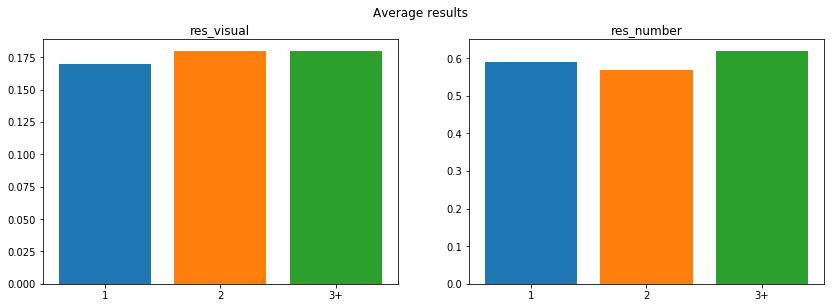

In [12]:
## Average results over all entries

memory_columns = ["res_visual", "res_number"]
fig, plots = plt.subplots(1, 2, figsize = (14, 4.5))

for column, plot in zip(memory_columns, plots):

    draw_bar_plot(plot, column, ['1', '2', '3+'], [
        round(hungry_level_1[column].mean(), 2),
        round(hungry_level_2[column].mean(), 2),
        round(hungry_level_3_plus[column].mean(), 2)
        ])

fig.suptitle("Average results")

Text(0.5,0.98,'Average results of averaged subjects results')

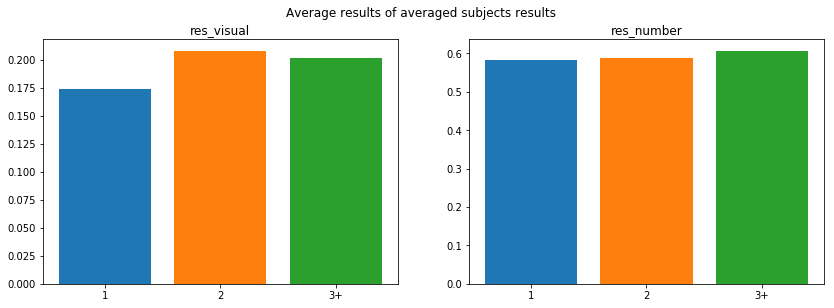

In [13]:
## Average results of averaged subjects results

memory_columns = ["res_visual", "res_number"]
fig, plots = plt.subplots(1, 2, figsize = (14, 4.5))

for column, plot in zip(memory_columns, plots):

    draw_bar_plot(plot, column, ['1', '2', '3+'], [
        grouped_hungry_subjects[column][0],
        grouped_hungry_subjects[column][1],
        grouped_hungry_subjects[column][5]
        ])

fig.suptitle("Average results of averaged subjects results")

## Add time from wakeup

In [14]:

# add awake delta
ts_wake = common.ts.apply(lambda x: x.replace(hour=0, minute=0, second=0)) + common.time_wake
delta = ((common.ts - ts_wake) + pd.Timedelta(days=1)) % pd.Timedelta(days=1)
# common["awake_delta"] = delta / np.timedelta64(1, 's')

# bin deltas into 1h boxes
#pd.cut(delta)
#delta = pd.timedelta_range(start="0 hour" , freq="1H", periods=25, closed="right")
common['awake_bin'] = [r.seconds // 3600 + 1 for r in delta]
#common

# fine best time per person 
res_df = common[["user_id", "res_number", "res_visual", "res_reaction"]]
best = res_df.groupby("user_id").idxmax()

assert best.index.all(general.index)
for c in res_columns:
    bins = common.loc[best[c]][["awake_bin", "user_id"]]
    bins = bins.set_index("user_id")
    general["best_" + c] = bins

In [15]:
# add sleep time

sleep = ((common.time_wake - common.time_sleep) + pd.Timedelta(days=1)) % pd.Timedelta(days=1)
common["sleep_bin"] = pd.cut(sleep.dt.seconds, [0, 60*60*6, 60*60*8, 60*60*24])

common.groupby("sleep_bin").mean()

,user_id,res_number,res_reaction,res_visual,awake_bin
sleep_bin,,,,,
"(0, 21600]",9.071429,0.545455,0.806430,0.078733,9.642857
"(21600, 28800]",14.098592,0.582586,0.856099,0.192112,8.802817
"(28800, 86400]",15.049587,0.598798,0.845669,0.172053,8.280992


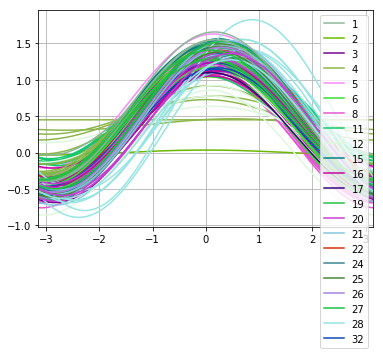

In [16]:
# Andrews Curves
from pandas.plotting import andrews_curves


#long_res = pd.wide_to_long(res, "res", i="id", j="game_type", suffix="\w+", sep="_").reset_index()

#del long_res["id"]
#means = long_res.groupby(["user_id", "game_type"]).mean().reset_index()
#del means["user_id"]

andrews_curves(res_df, "user_id")

#fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))

#for column,plot in zip(columns,plots) :
    #res[column].plot.bar(ax=plot)

In [17]:
# Learning model space
data = common.drop("ts", axis=1).join(general, on="user_id").drop(labels=["user_id", "time_sleep", "time_wake"], axis=1)
one_hotted = pd.get_dummies(data, drop_first=True)



In [18]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
# Unsupervised learning

# fit clustering
X = one_hotted.drop(["best_res_reaction", "best_res_visual", "best_res_number"], axis=1)
y = one_hotted[["best_res_reaction", "best_res_visual", "best_res_number"]]

scaler = StandardScaler()
X = scaler.fit_transform(X)
db = KMeans(n_clusters=16).fit(X)
# test clustering
# for each cluster
y["cluster"] = db.labels_
    # => assume cluster has better accuracy
    #    use best of cluster??

yy = pd.crosstab(y.cluster, [y.best_res_reaction, y.best_res_number, y.best_res_visual])



In [20]:
def get_prediction(me = None):

    if not me:
        me = {'res_number': 7, 'res_reaction': 289, 'res_visual':16280, 'hungry': '2','sleepy':'2', 'stressed':'2', 'fatigue_mental':'Yes', 'stress':'2',
       'fatigue_physical':'No physical activity', 'drugs':'No', 'awake_bin':7, 'gender':'Male', 'age': '18 - 30', 'prev_test': 'Yes', 'pys_activity': '1 - 4h per week', 'sick': 'No', 'pain_general':'1', 'pain_digest': 'No', 'sleep_regular':"The time of falling asleep differs from yesterdays' between 1h and 4h."}

    for k,v in me.items():
        me[k] = [v]

    df_me = pd.DataFrame.from_dict(me)

    cats = data.dtypes[data.dtypes == 'category']
    df_me[cats.index] = df_me[cats.index].astype(cats)

    one_me = pd.get_dummies(df_me, drop_first=True)

    trs_me = scaler.transform(one_me)
    cluster = db.predict(trs_me)[0]
    return yy.loc[cluster].idxmax()

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [22]:
# TODO use this to later correct for learning
model = ols("res_visual ~ awake_bin", common).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             res_visual   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4048
Date:                Sun, 20 Jan 2019   Prob (F-statistic):              0.525
Time:                        20:15:57   Log-Likelihood:                 115.31
No. Observations:                 206   AIC:                            -226.6
Df Residuals:                     204   BIC:                            -220.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1624      0.019      8.679      0.000       0.126       0.199
awake_bin      0.0012      0.002      0.636      0.525      -0.003       0.005
==============================================================================
Omnibus:                      121.981   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              788.837
Skew:                           2.267   Prob(JB):                    5.08e-172
Kurtosis:                      11.446   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

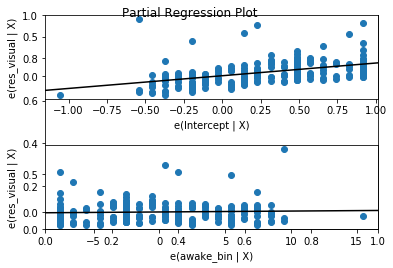

In [23]:
fig,plots  = plt.subplots(1,1)
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

### Effects of caffeine on reaction time

In [24]:
df = pd.DataFrame(common.res_reaction)
df["cof"] = common.drugs
caffeine = df.loc[df['cof'] == "Caffeine"].res_reaction.mean()
mean_all = df.res_reaction.mean()
without = df.loc[df['cof'] != "Caffeine"].res_reaction.mean()
print("Average reaction time after caffeine consumption: ", caffeine)
print("Overall average reaction time: ", mean_all)
print("Average reaction time without caffeine consumption: ", without)

Average reaction time after caffeine consumption:  0.8940562303807833
Overall average reaction time:  0.8465974365327871
Average reaction time without caffeine consumption:  0.837216047051206


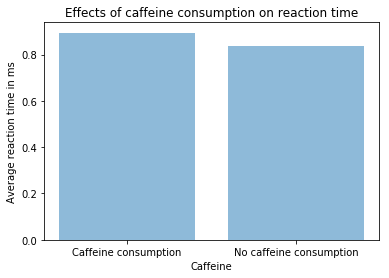

In [25]:
objects = ("Caffeine consumption", "No caffeine consumption")
performance = [caffeine, without]
plt.bar(objects, performance, align='center', alpha=0.5)
plt.xlabel("Caffeine")
plt.ylabel("Average reaction time in ms")
plt.title("Effects of caffeine consumption on reaction time")
plt.show()

In [26]:
from scipy import stats
caf = df.loc[df['cof'] == "Caffeine"].res_reaction
no_caf = df.loc[df['cof'] != "Caffeine"].res_reaction
stats.ttest_ind(caf, no_caf)

Ttest_indResult(statistic=2.003838563880214, pvalue=0.04641017658944742)

### Effects of intensive mental work on test results

In [27]:
grouped_ment_subjects = \
    common[["user_id", "fatigue_mental", "res_number", "res_visual", "res_reaction"]]\
        .groupby(["user_id", "fatigue_mental"]).mean()\
        .groupby("fatigue_mental").mean()
grouped_ment_subjects

,res_number,res_visual,res_reaction
fatigue_mental,,,
No,0.589344,0.184834,0.855518
Yes,0.581791,0.198872,0.862333


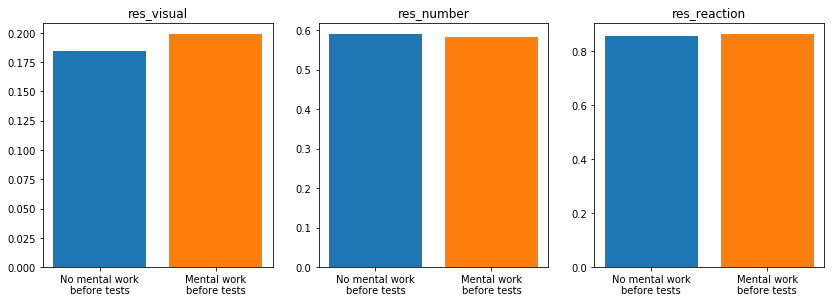

In [28]:
val_columns = ["res_visual", "res_number", "res_reaction"]
fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))

for column, plot in zip(val_columns, plots):

    draw_bar_plot(plot, column, ['No mental work\nbefore tests', 'Mental work\nbefore tests'], [
        grouped_ment_subjects[column][0],
        grouped_ment_subjects[column][1]
        ])

In [29]:
df = pd.DataFrame(common)
act_y = df.loc[df['fatigue_mental'] == "Yes"].res_reaction
no_act = df.loc[df['fatigue_mental'] == "No"].res_reaction
stats.ttest_ind(act_y, no_act)

Ttest_indResult(statistic=0.8480469753364583, pvalue=0.39740573312861294)

### Effects of physical activity on test results

In [30]:
grouped_act_subjects = \
    common[["user_id", "fatigue_physical", "res_number", "res_visual", "res_reaction"]]\
        .groupby(["user_id", "fatigue_physical"]).mean()\
        .groupby("fatigue_physical").mean()
grouped_act_subjects

,res_number,res_visual,res_reaction
fatigue_physical,,,
I've had an intensive workout,0.636364,0.182526,0.815214
"Light activity (walking, cleaning etc.)",0.600999,0.180204,0.856505
No physical activity,0.590304,0.183039,0.865092


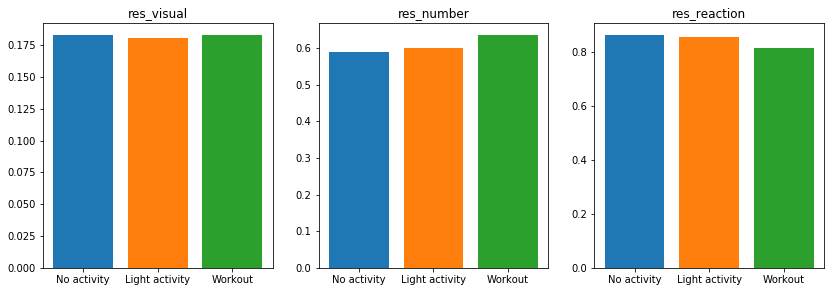

In [31]:
act_columns = ["res_visual", "res_number", "res_reaction"]
fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))

for column, plot in zip(act_columns, plots):

    draw_bar_plot(plot, column, ['No activity', 'Light activity', 'Workout'], [
        grouped_act_subjects[column][2],
        grouped_act_subjects[column][1],
        grouped_act_subjects[column][0]
        ])

In [32]:
df = pd.DataFrame(common)
#1. reaction time
light = df.loc[df['fatigue_physical'] == "Light activity (walking, cleaning etc.)"].res_reaction
no_act = df.loc[df['fatigue_physical'] != "No physical activity"].res_reaction
light_rt = stats.ttest_ind(light, no_act)

#2. number memory
light2 = df.loc[df['fatigue_physical'] == "Light activity (walking, cleaning etc.)"].res_number
no_act2 = df.loc[df['fatigue_physical'] != "No physical activity"].res_number
light_nr = stats.ttest_ind(light2, no_act2)

#3. visual memory
light3 = df.loc[df['fatigue_physical'] == "Light activity (walking, cleaning etc.)"].res_visual
no_act3 = df.loc[df['fatigue_physical'] != "No physical activity"].res_visual
light_vis = stats.ttest_ind(light3, no_act3)

print("Light - reaction: ", light_rt)
print("Light - number: ", light_nr)
print("Light - visual: ", light_vis)

#1. reaction time
intens = df.loc[df['fatigue_physical'] == "I've had an intensive workout"].res_reaction
int_rt = stats.ttest_ind(intens, no_act)

#2. number memory
intens2 = df.loc[df['fatigue_physical'] == "I've had an intensive workout"].res_number
int_nr = stats.ttest_ind(intens2, no_act2)

#3. visual memory
intens3 = df.loc[df['fatigue_physical'] == "I've had an intensive workout"].res_visual
int_vis = stats.ttest_ind(intens3, no_act3)

print("INtensive - reaction: ", int_rt)
print("Intensive - number: ", int_nr)
print("Intensive - visual: ", int_vis)

Light - reaction:  Ttest_indResult(statistic=0.0998443670146787, pvalue=0.9205765843314941)
Light - number:  Ttest_indResult(statistic=-0.17740770259723704, pvalue=0.8593833012429184)
Light - visual:  Ttest_indResult(statistic=0.029778803634968324, pvalue=0.9762757383930517)
INtensive - reaction:  Ttest_indResult(statistic=-0.4432450405762908, pvalue=0.6585181080113913)
Intensive - number:  Ttest_indResult(statistic=0.7903004028428641, pvalue=0.4311681492523618)
Intensive - visual:  Ttest_indResult(statistic=-0.13767885521254505, pvalue=0.8907630184951769)


### Test results based on sleepiness levels

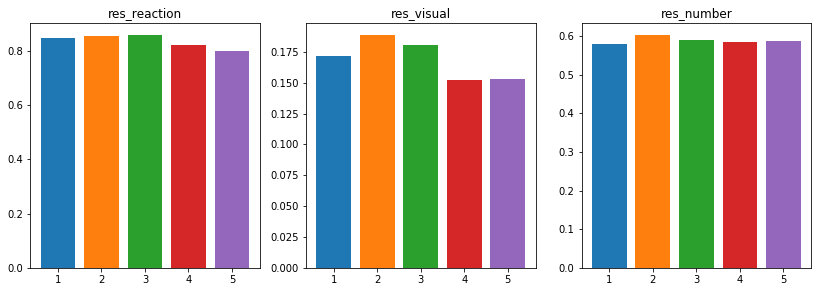

In [33]:
grouped_sleepy_subjects = \
    common[["user_id", "sleepy", "res_number", "res_visual", "res_reaction"]]\
        .groupby(["user_id", "sleepy"]).mean()\
        .groupby("sleepy").mean()

        
## Average results of averaged subjects results

fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))

for column, plot in zip(res_columns, plots):

    draw_bar_plot(plot, column, ['1', '2', '3', '4', '5'], [
        grouped_sleepy_subjects[column][0],
        grouped_sleepy_subjects[column][1],
        grouped_sleepy_subjects[column][2],
        grouped_sleepy_subjects[column][3],
        grouped_sleepy_subjects[column][4]
        ])

### Effects of length of night sleep on test results

                  user_id  res_number  res_reaction  res_visual  awake_bin
sleep_bin                                                                 
(0, 21600]       9.071429    0.545455      0.806430    0.078733   9.642857
(21600, 28800]  14.098592    0.582586      0.856099    0.192112   8.802817
(28800, 86400]  15.049587    0.598798      0.845669    0.172053   8.280992


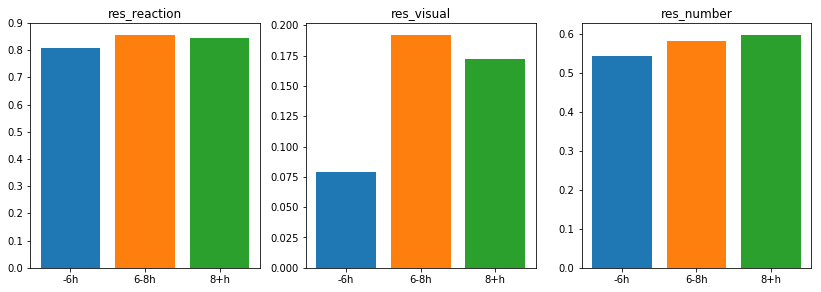

In [34]:
sleep = ((common.time_wake - common.time_sleep) + pd.Timedelta(days=1)) % pd.Timedelta(days=1)
common["sleep_bin"] = pd.cut(sleep.dt.seconds, [0, 60*60*6, 60*60*8, 60*60*24])
grouped_sleeptime_subjects = common.groupby("sleep_bin").mean()

fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))

print(grouped_sleeptime_subjects)

for column, plot in zip(res_columns, plots):

    draw_bar_plot(plot, column, ['-6h', '6-8h', '8+h'], [
        grouped_sleeptime_subjects[column].iloc[0],
        grouped_sleeptime_subjects[column].iloc[1],
        grouped_sleeptime_subjects[column].iloc[2],
        ])